# Stock Price Analysis & Prediction

In this notebook, we will discover and explore data from the stock market, specifically the Tesla stock prices from 28th June, 2010 to 23rd March, 2022. We will also be predicting future stock prices by usign different types of Neural Networks like RNN, LSTM & GRU.

We'll be follwoing the steps as mentioned below:

    1. EDA
        * Trend
        * Seasonality
    2. Data Preprocessing & Feature Engineering
        * Normalization
        * Time embedding
    3. Train different NN models for forecasting 
        * RNN
        * LSTM
        * GRU
    4. Evaulate
        * Intrinsic- MAE, MSE
        * Extrinsic- MAPE
    5. Optimizing Hyperparameters

***   

#### Getting the Data
[TESLA Stock Data](https://www.kaggle.com/datasets/varpit94/tesla-stock-data-updated-till-28jun2021)

In [102]:
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *

%matplotlib inline


In [103]:
batch_size = 128
seq_len = 32

In [104]:
# load dataset
df_path = '../data/TSLA.csv'
dataset = read_csv(df_path, header=0, parse_dates= True , index_col= "Date")
values = dataset.values
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


### 1. EDA

In [105]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [106]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


### # Trend

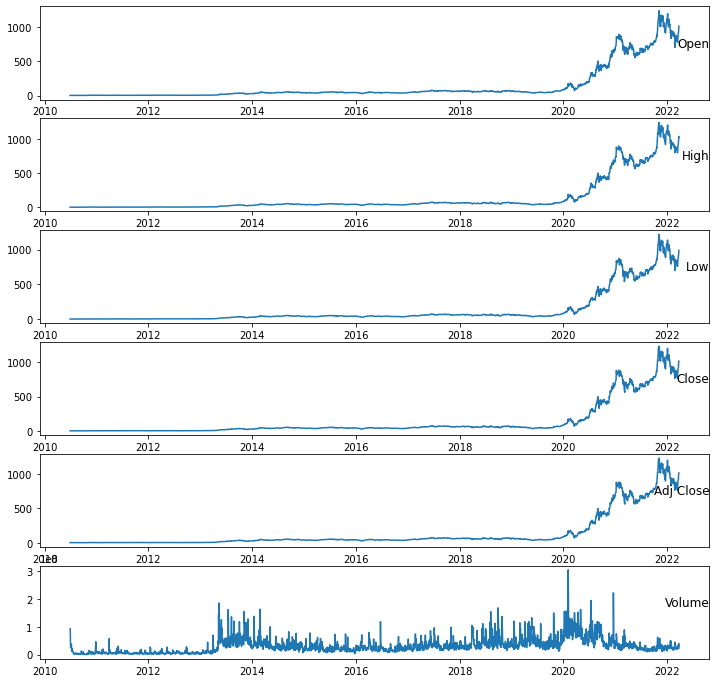

In [107]:
plt.figure(figsize=(12, 12))

columns = [str(c) for c in dataset.columns]

for i, c in enumerate(columns):
    pyplot.subplot(len(columns), 1, i+1)
    pyplot.plot(dataset[c])
    pyplot.title(c, y=0.5, loc='right')

plt.show()

**Note** A clear upward trend starting at 2020

### # Seasonality

We will check for seasonal patterns in the closing price

In [108]:
plot_df = dataset.copy()
plot_df["weekday_name"] = plot_df.index.day_name()
plot_df["weekday"] = plot_df.index.weekday
plot_df["week"] = plot_df.index.isocalendar().week
plot_df["day"] = plot_df.index.day
plot_df["hour"] = plot_df.index.hour
plot_df["date"] = plot_df.index.date
plot_df["month"] = plot_df.index.month
plot_df["month_name"] = plot_df.index.month_name()
plot_df["year"] = plot_df.index.year

#Making ordered categoricals to make for sorted plots
plot_df['month_name'] = pd.Categorical(plot_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
plot_df['weekday_name'] = pd.Categorical(plot_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)


In [109]:
plot_df_monthly = plot_df[plot_df.year.isin([2019, 2020, 2021, 2022])].groupby(['year', 'month_name'])['Close'].mean().dropna().reset_index()

In [110]:
fig = px.line(plot_df_monthly, x="month_name", y='Close', color="year", title="Seasonal Plot - Monthly")
fig.show()

**Note** Prices seem to be downward at the beginning of the year, while keeps the upward trend for the rest of the year.

### 2. Data Preprocessing & Feature Engineering

### # Approach 1: Normalization

In [111]:
norm_df = dataset.copy()
norm_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


In [112]:
norm_target_df = dataset[['Close']].copy()
norm_target_df

,Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2022-03-18,905.390015
2022-03-21,921.159973
2022-03-22,993.979980


In [113]:
# Dataframe to numpy array
norm_X = norm_df.values
norm_X

array([[3.80000000e+00, 5.00000000e+00, 3.50800000e+00, 4.77800000e+00,
        4.77800000e+00, 9.38315000e+07],
       [5.15800000e+00, 6.08400000e+00, 4.66000000e+00, 4.76600000e+00,
        4.76600000e+00, 8.59355000e+07],
       [5.00000000e+00, 5.18400000e+00, 4.05400000e+00, 4.39200000e+00,
        4.39200000e+00, 4.10940000e+07],
       ...,
       [9.30000000e+02, 9.97859985e+02, 9.21750000e+02, 9.93979980e+02,
        9.93979980e+02, 3.52895000e+07],
       [9.79940002e+02, 1.04069995e+03, 9.76400024e+02, 9.99109985e+02,
        9.99109985e+02, 4.02254000e+07],
       [1.00972998e+03, 1.02448999e+03, 9.88799988e+02, 1.01391998e+03,
        1.01391998e+03, 2.29019000e+07]])

In [114]:
norm_y = norm_target_df.values
norm_y

array([[   4.778   ],
       [   4.766   ],
       [   4.392   ],
       ...,
       [ 993.97998 ],
       [ 999.109985],
       [1013.919983]])

***

In [115]:
scaler_X = MinMaxScaler()
norm_X[:] = scaler_X.fit_transform(norm_X[:])
norm_X

array([[4.64594174e-04, 1.34982149e-03, 4.21744904e-04, 1.31893210e-03,
        1.31893210e-03, 3.06604867e-01],
       [1.56759922e-03, 2.22389944e-03, 1.37067094e-03, 1.30915016e-03,
        1.30915016e-03, 2.80639852e-01],
       [1.43926727e-03, 1.49818896e-03, 8.71496305e-04, 1.00427957e-03,
        1.00427957e-03, 1.33184151e-01],
       ...,
       [7.52749776e-01, 8.01937480e-01, 7.56796518e-01, 8.07678787e-01,
        8.07678787e-01, 1.14096774e-01],
       [7.93312423e-01, 8.36481271e-01, 8.01812864e-01, 8.11860573e-01,
        8.11860573e-01, 1.30327868e-01],
       [8.17508664e-01, 8.23410451e-01, 8.12026969e-01, 8.23933120e-01,
        8.23933120e-01, 7.33616901e-02]])

In [116]:
scaler_y = MinMaxScaler()
norm_y[:] = scaler_y.fit_transform(norm_y[:])
norm_y

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.80767879],
       [0.81186057],
       [0.82393312]])

#### # Create sequence from scaled dataset

In [117]:
# Sequenced dataset
X_scaled, y_scaled = [], []
for i in range(seq_len, len(norm_X)):
    X_scaled.append(norm_X[i-seq_len:i]) # Chunks of training data with a length of seq_len
    y_scaled.append(norm_y[i,0])
X_scaled, y_scaled = np.array(X_scaled), np.array(y_scaled)

In [118]:
print(f'Input instance: {X_scaled[0]}')
print(f'Targets instance: {y_scaled[0]}')

Input instance: [[4.64594174e-04 1.34982149e-03 4.21744904e-04 1.31893210e-03
  1.31893210e-03 3.06604867e-01]
 [1.56759922e-03 2.22389944e-03 1.37067094e-03 1.30915016e-03
  1.30915016e-03 2.80639852e-01]
 [1.43926727e-03 1.49818896e-03 8.71496305e-04 1.00427957e-03
  1.00427957e-03 1.33184151e-01]
 [1.11437624e-03 1.04341040e-03 6.14495504e-04 5.54310154e-04
  5.54310154e-04 8.25596059e-02]
 [6.27039689e-04 5.43476512e-04 1.40032488e-04 5.05400434e-05
  5.05400434e-05 1.10956375e-01]
 [4.22358340e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.11857390e-01]
 [0.00000000e+00 1.43529405e-04 9.71990208e-05 2.70633781e-04
  2.70633781e-04 1.24841541e-01]
 [2.33921542e-04 2.04811623e-04 2.58648242e-04 2.60851837e-04
  2.60851837e-04 6.46511116e-02]
 [2.94026383e-04 2.32227352e-04 3.32783088e-04 2.03790498e-04
  2.03790498e-04 3.42648754e-02]
 [2.03056894e-04 3.24150679e-04 3.16308678e-04 3.81495812e-04
  3.81495812e-04 4.21175167e-02]
 [2.92401928e-04 5.67666862e-04 4.

In [119]:
print(f'input shape: {X_scaled.shape}')
print(f'target shape: {y_scaled.shape}')

input shape: (2924, 32, 6)
target shape: (2924,)


#### # Train-Test split of scaled data

In [120]:
# 80% to Train , 20% to Test [- the window 32 = 2924*0.8]
train_size = int(len(X_scaled)*0.80)
val_size = int(len(X_scaled)*0.10)
test_size = len(X_scaled) - train_size - val_size

X_scaled_train = X_scaled[:train_size,]
y_scaled_train = y_scaled[:train_size,]
X_scaled_val = X_scaled[train_size:train_size + val_size,]
y_scaled_val = y_scaled[train_size:train_size + val_size,]
X_scaled_test = X_scaled[train_size + val_size:,]
y_scaled_test = y_scaled[train_size + val_size:,]

print('X_scaled_train: {}'.format(X_scaled_train.shape))
print('y_scaled_train: {}'.format(y_scaled_train.shape))
print('X_scaled_val: {}'.format(X_scaled_val.shape))
print('y_scaled_val: {}'.format(y_scaled_val.shape))
print('X_scaled_test: {}'.format(X_scaled_test.shape))
print('y_scaled_test: {}'.format(y_scaled_test.shape))

X_scaled_train: (2339, 32, 6)
y_scaled_train: (2339,)
X_scaled_val: (292, 32, 6)
y_scaled_val: (292,)
X_scaled_test: (293, 32, 6)
y_scaled_test: (293,)


***
***
***

### # Approach 2: Time Embedding (Time2Vec)
We will generate another set of time features by implementing a Time2Vector encoder. Then we will test 2 cases- 1st with only the price feautres, and 2nd with a combination of time-features & price features

In [121]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
        
        return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)


### 3. Modeling 

#### # For only price features

In [122]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.models import Model
from keras.layers import Input, Dense, LSTM, GRU, SimpleRNN, Concatenate
from tensorflow.keras.layers import Dropout
import keras_tuner as kt
import keras

In [123]:
n_features = 6

def build_model(hp):
    model = Sequential()
    model_type = hp.Choice("model_type", ["gru", "lstm", "rnn"])

    if model_type == "gru":
        model.add(GRU(seq_len,return_sequences=True, input_shape=(seq_len,n_features)))
        for i in range(hp.Int('gru_n_layers', 1, 2)):
            model.add(GRU(hp.Int(f'gru_{i}_units',min_value=32,max_value=128,step=32),return_sequences=True))
        model.add(GRU(seq_len))
    elif model_type == "lstm":
        model.add(LSTM(seq_len,return_sequences=True, input_shape=(seq_len,n_features)))
        for i in range(hp.Int('lstm_n_layers', 1, 2)):
            model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),return_sequences=True))
        model.add(LSTM(seq_len))
    else:
        model.add(SimpleRNN(seq_len,return_sequences=True, input_shape=(seq_len,n_features)))
        for i in range(hp.Int('rnn_n_layers', 1, 2)):
            model.add(SimpleRNN(hp.Int(f'rnn_{i}_units',min_value=32,max_value=128,step=32),return_sequences=True))
        model.add(SimpleRNN(seq_len))

    if hp.Boolean("dropout"):
        model.add(Dropout(hp.Float('dropout_rate',min_value=0.2,max_value=0.4,step=0.1)))
    

    model.add(Dense(32)) 
    model.add(Dense(1))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=opt, metrics=['mse', 'mae', 'mape'])
    
    return model


In [124]:
tuner= kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=40,
        directory="/kaggle/working/tmp/tb",
        overwrite=True,
)

In [125]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

tuner.search(
        x=X_scaled_train,
        y=y_scaled_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_scaled_val,y_scaled_val),
        callbacks=[early_stopping, TensorBoard("/kaggle/working/tmp/tb")],
)

Trial 40 Complete [00h 01m 24s]
val_loss: 0.05056731775403023

Best val_loss So Far: 0.00045117578702047467
Total elapsed time: 00h 30m 42s


In [126]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32, 32)            3840      
_________________________________________________________________
gru_1 (GRU)                  (None, 32, 64)            18816     
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 33,153
Trainable params: 33,153
Non-trainable params: 0
_________________________________________________________________


In [127]:
tuner.results_summary()

Results summary
Results in /kaggle/working/tmp/tb/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
model_type: gru
gru_n_layers: 1
gru_0_units: 64
dropout: False
rnn_n_layers: 1
rnn_0_units: 96
dropout_rate: 0.4000000000000001
lstm_n_layers: 2
lstm_0_units: 32
gru_1_units: 96
rnn_1_units: 64
lstm_1_units: 128
Score: 0.00045117578702047467
Trial summary
Hyperparameters:
model_type: gru
gru_n_layers: 2
gru_0_units: 64
dropout: False
rnn_n_layers: 2
rnn_0_units: 96
dropout_rate: 0.4000000000000001
lstm_n_layers: 1
lstm_0_units: 64
gru_1_units: 128
Score: 0.00045793227036483586
Trial summary
Hyperparameters:
model_type: gru
gru_n_layers: 1
gru_0_units: 96
dropout: False
rnn_n_layers: 1
rnn_0_units: 64
dropout_rate: 0.30000000000000004
lstm_n_layers: 1
lstm_0_units: 64
gru_1_units: 64
rnn_1_units: 96
lstm_1_units: 64
Score: 0.0006958962767384946
Trial summary
Hyperparameters:
model_type: gru
gru_n_layers: 2
gru_0_units: 32
dropout: True
rnn_n_layers: 1
rnn_0_units: 32


In [128]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_scaled_train, y_scaled_train, epochs= 50, batch_size= 32, 
                            validation_data=(X_scaled_val, y_scaled_val))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
74/74 [==============================] - 5s 19ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0270 - mape: 572.3954 - val_loss: 9.0407e-04 - val_mse: 9.0407e-04 - val_mae: 0.0190 - val_mape: 7.4906
Epoch 2/50
74/74 [==============================] - 1s 9ms/step - loss: 4.3118e-06 - mse: 4.3118e-06 - mae: 0.0015 - mape: 17.7194 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0217 - val_mape: 8.2155
Epoch 3/50
74/74 [==============================] - 1s 9ms/step - loss: 3.1870e-06 - mse: 3.1870e-06 - mae: 0.0013 - mape: 12.8202 - val_loss: 8.9236e-04 - val_mse: 8.9236e-04 - val_mae: 0.0185 - val_mape: 6.8712
Epoch 4/50
74/74 [==============================] - 1s 9ms/step - loss: 3.2985e-06 - mse: 3.2985e-06 - mae: 0.0013 - mape: 15.1048 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0206 - val_mape: 7.6636
Epoch 5/50
74/74 [==============================] - 1s 9ms/step - loss: 3.0063e-06 - mse: 3.0063e-06 - mae: 0.0013 - mape: 13.4793 - val_loss: 8.8868e-04 - val_mse: 8.886

In [129]:
model = tuner.hypermodel.build(best_hps)
# Retrain the model
history = model.fit(X_scaled_train, y_scaled_train, epochs= best_epoch, batch_size= 32, 
                            validation_data=(X_scaled_val, y_scaled_val))

Epoch 1/11
74/74 [==============================] - 5s 22ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0261 - mape: 441.2983 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0581 - val_mape: 18.9084
Epoch 2/11
74/74 [==============================] - 1s 9ms/step - loss: 8.2378e-06 - mse: 8.2378e-06 - mae: 0.0020 - mape: 23.6622 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0252 - val_mape: 8.9216
Epoch 3/11
74/74 [==============================] - 1s 9ms/step - loss: 3.3696e-06 - mse: 3.3696e-06 - mae: 0.0013 - mape: 12.6770 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0246 - val_mape: 8.6472
Epoch 4/11
74/74 [==============================] - 1s 8ms/step - loss: 3.6074e-06 - mse: 3.6074e-06 - mae: 0.0014 - mape: 15.6450 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0242 - val_mape: 8.5382
Epoch 5/11
74/74 [==============================] - 1s 8ms/step - loss: 3.2662e-06 - mse: 3.2662e-06 - mae: 0.0013 - mape: 14.7383 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0241

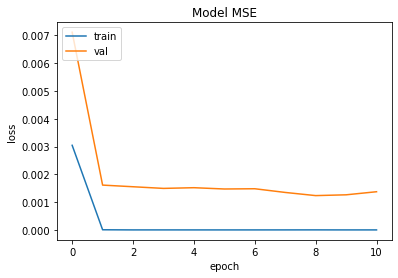

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

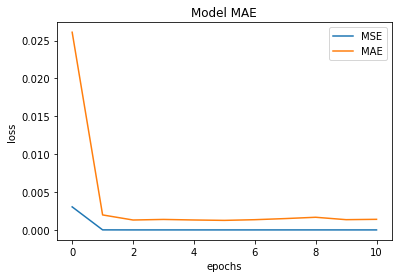

In [144]:
plt.plot(history.history["loss"])
plt.plot(history.history["mae"])
plt.legend(['MSE','MAE'])
plt.title("Model MAE")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [132]:
# #inverse predictions scaling
predictions = model.predict(X_scaled_test)
predictions = scaler_y.inverse_transform(predictions)
predictions.shape

(293, 1)

In [133]:
predictions[-10:]

array([[712.8885 ],
       [704.08795],
       [688.95   ],
       [687.17523],
       [696.41943],
       [709.1249 ],
       [725.51074],
       [740.82056],
       [764.54004],
       [782.7759 ]], dtype=float32)

In [134]:
# #inverse y_scaled_val scaling
y_scaled_test_inv = scaler_y.inverse_transform(np.array(y_scaled_test).reshape(-1, 1))
y_scaled_test_inv[-10:]

array([[ 795.349976],
       [ 766.369995],
       [ 801.890015],
       [ 840.22998 ],
       [ 871.599976],
       [ 905.390015],
       [ 921.159973],
       [ 993.97998 ],
       [ 999.109985],
       [1013.919983]])

In [135]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()


    return mse, mae, mape

In [136]:
mse, mae , mape = compute_metrics(y_scaled_test_inv.flatten(), predictions.flatten())
print(f"mse: {mse}, mae: {mae}, mape: {mape}")

mse: 20005.07421875, mae: 121.77081298828125, mape: 14.13724136352539


In [137]:
train_val = dataset.iloc[:train_size + val_size , :]
train_val

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2020-12-02,556.440002,571.539978,541.210022,568.820007,568.820007,47775700
2020-12-03,590.020020,598.969971,582.429993,593.380005,593.380005,42552000
2020-12-04,591.010010,599.039978,585.500000,599.039978,599.039978,29401300


In [138]:
test = dataset.iloc[train_size + val_size:-32, :]
test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-09,653.690002,654.320007,588.000000,604.479980,604.479980,71291200
2020-12-10,574.369995,627.750000,566.340027,627.070007,627.070007,67083200
2020-12-11,615.010010,624.000000,596.799988,609.989990,609.989990,46475000
2020-12-14,619.000000,642.750000,610.200012,639.830017,639.830017,52040600
2020-12-15,643.280029,646.900024,623.799988,633.250000,633.250000,45071500
...,...,...,...,...,...,...
2022-02-01,935.210022,943.700012,905.000000,931.250000,931.250000,24379400
2022-02-02,928.179993,931.500000,889.409973,905.659973,905.659973,22264300
2022-02-03,882.000000,937.000000,880.520020,891.140015,891.140015,26285200


In [139]:
test['Predictions'] = predictions
test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2020-12-09,653.690002,654.320007,588.000000,604.479980,604.479980,71291200,731.526428
2020-12-10,574.369995,627.750000,566.340027,627.070007,627.070007,67083200,730.668213
2020-12-11,615.010010,624.000000,596.799988,609.989990,609.989990,46475000,720.711365
2020-12-14,619.000000,642.750000,610.200012,639.830017,639.830017,52040600,708.407593
2020-12-15,643.280029,646.900024,623.799988,633.250000,633.250000,45071500,708.961060
...,...,...,...,...,...,...,...
2022-02-01,935.210022,943.700012,905.000000,931.250000,931.250000,24379400,709.124878
2022-02-02,928.179993,931.500000,889.409973,905.659973,905.659973,22264300,725.510742
2022-02-03,882.000000,937.000000,880.520020,891.140015,891.140015,26285200,740.820557


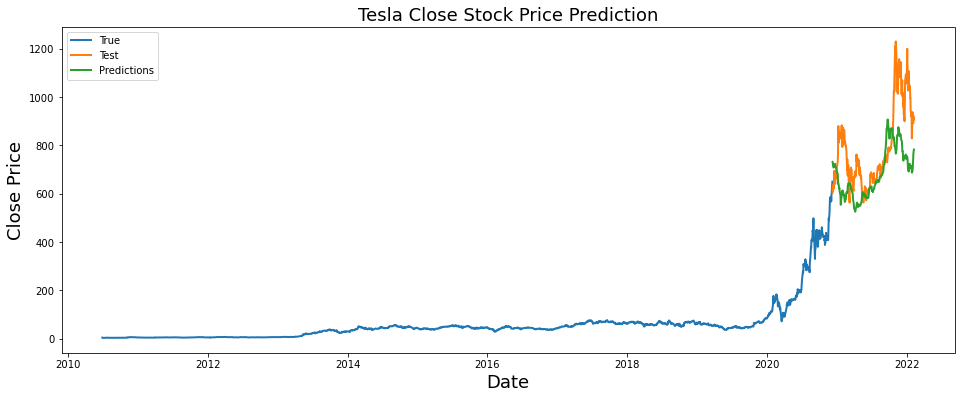

In [140]:
plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train_val['Close'], linewidth= 2)
plt.plot(test['Close'], linewidth= 2)
plt.plot(test["Predictions"], linewidth= 2)
plt.legend(['True', 'Test', 'Predictions'])
plt.ion()

### # For price & time features

In [147]:
n_features = 6

def build_model(hp):
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    
    '''Construct model'''
    in_seq = Input(shape=(seq_len, n_features))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    
    model_type = hp.Choice("model_type", ["gru", "lstm", "rnn"])
    
    if model_type == "gru":
        for i in range(hp.Int('gru_n_layers', 1, 2)):
            x = GRU(hp.Int(f'gru_{i}_units',min_value=seq_len,max_value=128,step=32),return_sequences=True)(x)
        x = GRU(seq_len)(x)
        
    elif model_type == "lstm":
        for i in range(hp.Int('lstm_n_layers', 1, 2)):
            x = LSTM(hp.Int(f'lstm_{i}_units',min_value=seq_len,max_value=128,step=32),return_sequences=True)(x)
        x = LSTM(seq_len)(x)
        
    else:
        for i in range(hp.Int('rnn_n_layers', 1, 2)):
            x = SimpleRNN(hp.Int(f'rnn_{i}_units',min_value=seq_len,max_value=128,step=32),return_sequences=True)(x)
        x = SimpleRNN(seq_len)(x)

    if hp.Boolean("dropout"):
        x = Dropout(hp.Float('dropout_rate',min_value=0.2,max_value=0.4,step=0.2))(x)

    x = Dense(32)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=in_seq, outputs=outputs)    
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=opt, metrics=['mse', 'mae', 'mape'])
    
    return model


In [148]:
tuner= kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=40,
        directory="/kaggle/working/tmp/tb2",
        overwrite=True,
)

In [149]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

tuner.search(
        x=X_scaled_train,
        y=y_scaled_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_scaled_val,y_scaled_val),
        callbacks=[early_stopping, TensorBoard("/kaggle/working/tmp/tb2")],
)

Trial 40 Complete [00h 01m 23s]
val_loss: 0.0225085262209177

Best val_loss So Far: 0.000254760030657053
Total elapsed time: 00h 19m 55s


In [150]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 6)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 32, 2)        128         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 8)        0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
gru (GRU)                       (None, 32, 64)       14208       concatenate[0][0]            

In [151]:
tuner.results_summary()

Results summary
Results in /kaggle/working/tmp/tb2/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
model_type: gru
gru_n_layers: 2
gru_0_units: 64
dropout: False
gru_1_units: 96
dropout_rate: 0.4
lstm_n_layers: 1
lstm_0_units: 128
rnn_n_layers: 1
rnn_0_units: 32
lstm_1_units: 64
rnn_1_units: 32
Score: 0.000254760030657053
Trial summary
Hyperparameters:
model_type: gru
gru_n_layers: 2
gru_0_units: 96
dropout: True
gru_1_units: 64
dropout_rate: 0.2
lstm_n_layers: 1
lstm_0_units: 64
Score: 0.00029695412376895547
Trial summary
Hyperparameters:
model_type: gru
gru_n_layers: 2
gru_0_units: 128
dropout: False
gru_1_units: 96
dropout_rate: 0.2
lstm_n_layers: 2
lstm_0_units: 64
rnn_n_layers: 1
rnn_0_units: 32
lstm_1_units: 64
rnn_1_units: 96
Score: 0.0002999355783686042
Trial summary
Hyperparameters:
model_type: gru
gru_n_layers: 2
gru_0_units: 96
dropout: True
gru_1_units: 96
dropout_rate: 0.2
lstm_n_layers: 2
lstm_0_units: 128
rnn_n_layers: 1
rnn_0_units: 128
lstm_1_uni

In [152]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_scaled_train, y_scaled_train, epochs= 50, batch_size= 32, 
                            validation_data=(X_scaled_val, y_scaled_val))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
74/74 [==============================] - 5s 21ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0276 - mape: 479.8324 - val_loss: 7.1377e-04 - val_mse: 7.1377e-04 - val_mae: 0.0175 - val_mape: 6.8617
Epoch 2/50
74/74 [==============================] - 1s 9ms/step - loss: 4.6213e-06 - mse: 4.6213e-06 - mae: 0.0016 - mape: 18.7615 - val_loss: 3.7980e-04 - val_mse: 3.7980e-04 - val_mae: 0.0129 - val_mape: 5.7905
Epoch 3/50
74/74 [==============================] - 1s 9ms/step - loss: 3.1786e-06 - mse: 3.1786e-06 - mae: 0.0013 - mape: 14.9033 - val_loss: 3.6740e-04 - val_mse: 3.6740e-04 - val_mae: 0.0127 - val_mape: 5.6720
Epoch 4/50
74/74 [==============================] - 1s 9ms/step - loss: 2.8558e-06 - mse: 2.8558e-06 - mae: 0.0012 - mape: 13.6707 - val_loss: 3.3711e-04 - val_mse: 3.3711e-04 - val_mae: 0.0123 - val_mape: 5.6575
Epoch 5/50
74/74 [==============================] - 1s 13ms/step - loss: 3.3644e-06 - mse: 3.3644e-06 - mae: 0.0014 - mape: 16.5004 - val_loss: 3.7527e-04

In [153]:
model = tuner.hypermodel.build(best_hps)
# Retrain the model
history = model.fit(X_scaled_train, y_scaled_train, epochs= best_epoch, batch_size= 32, 
                            validation_data=(X_scaled_val, y_scaled_val))

Epoch 1/20
74/74 [==============================] - 5s 20ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0269 - mape: 456.9234 - val_loss: 3.4040e-04 - val_mse: 3.4040e-04 - val_mae: 0.0123 - val_mape: 5.5987
Epoch 2/20
74/74 [==============================] - 1s 9ms/step - loss: 3.8691e-06 - mse: 3.8691e-06 - mae: 0.0015 - mape: 19.3789 - val_loss: 3.8920e-04 - val_mse: 3.8920e-04 - val_mae: 0.0129 - val_mape: 5.6091
Epoch 3/20
74/74 [==============================] - 1s 10ms/step - loss: 2.6354e-06 - mse: 2.6354e-06 - mae: 0.0012 - mape: 13.1599 - val_loss: 3.3886e-04 - val_mse: 3.3886e-04 - val_mae: 0.0120 - val_mape: 5.2124
Epoch 4/20
74/74 [==============================] - 1s 9ms/step - loss: 2.2762e-06 - mse: 2.2762e-06 - mae: 0.0011 - mape: 11.3015 - val_loss: 3.3900e-04 - val_mse: 3.3900e-04 - val_mae: 0.0120 - val_mape: 5.2182
Epoch 5/20
74/74 [==============================] - 1s 9ms/step - loss: 2.4937e-06 - mse: 2.4937e-06 - mae: 0.0011 - mape: 13.4939 - val_loss: 3.2720e-04

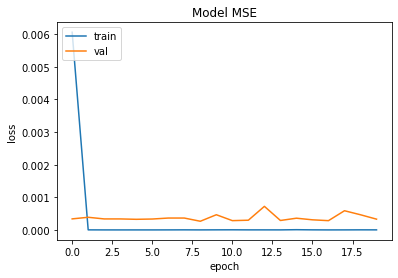

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

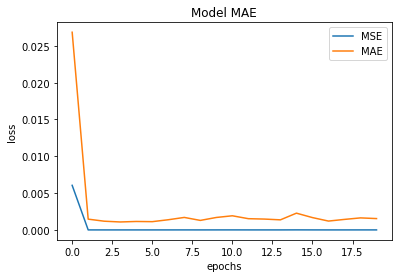

In [164]:
plt.plot(history.history["loss"])
plt.plot(history.history["mae"])
plt.legend(['MSE','MAE'])
plt.title("Model MAE")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [156]:
# #inverse predictions scaling
predictions = model.predict(X_scaled_test)
predictions = scaler_y.inverse_transform(predictions)
predictions.shape

(293, 1)

In [157]:
predictions[-10:]

array([[799.35846],
       [771.3138 ],
       [735.6737 ],
       [746.8332 ],
       [787.4421 ],
       [816.3365 ],
       [842.3225 ],
       [863.74475],
       [899.8216 ],
       [924.2975 ]], dtype=float32)

In [158]:
# #inverse y_scaled_val scaling
y_scaled_test_inv = scaler_y.inverse_transform(np.array(y_scaled_test).reshape(-1, 1))
y_scaled_test_inv[-10:]

array([[ 795.349976],
       [ 766.369995],
       [ 801.890015],
       [ 840.22998 ],
       [ 871.599976],
       [ 905.390015],
       [ 921.159973],
       [ 993.97998 ],
       [ 999.109985],
       [1013.919983]])

In [159]:
mse, mae , mape = compute_metrics(y_scaled_test_inv.flatten(), predictions.flatten())
print(f"mse: {mse}, mae: {mae}, mape: {mape} with time2vec")

mse: 3662.66650390625, mae: 46.362735748291016, mape: 5.30113410949707 with time2vec


In [160]:
train_val = dataset.iloc[:train_size + val_size , :]
train_val

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2020-12-02,556.440002,571.539978,541.210022,568.820007,568.820007,47775700
2020-12-03,590.020020,598.969971,582.429993,593.380005,593.380005,42552000
2020-12-04,591.010010,599.039978,585.500000,599.039978,599.039978,29401300


In [161]:
test = dataset.iloc[train_size + val_size:-32, :]
test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-09,653.690002,654.320007,588.000000,604.479980,604.479980,71291200
2020-12-10,574.369995,627.750000,566.340027,627.070007,627.070007,67083200
2020-12-11,615.010010,624.000000,596.799988,609.989990,609.989990,46475000
2020-12-14,619.000000,642.750000,610.200012,639.830017,639.830017,52040600
2020-12-15,643.280029,646.900024,623.799988,633.250000,633.250000,45071500
...,...,...,...,...,...,...
2022-02-01,935.210022,943.700012,905.000000,931.250000,931.250000,24379400
2022-02-02,928.179993,931.500000,889.409973,905.659973,905.659973,22264300
2022-02-03,882.000000,937.000000,880.520020,891.140015,891.140015,26285200


In [162]:
test['Predictions'] = predictions
test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2020-12-09,653.690002,654.320007,588.000000,604.479980,604.479980,71291200,834.981567
2020-12-10,574.369995,627.750000,566.340027,627.070007,627.070007,67083200,821.847717
2020-12-11,615.010010,624.000000,596.799988,609.989990,609.989990,46475000,783.828491
2020-12-14,619.000000,642.750000,610.200012,639.830017,639.830017,52040600,759.546631
2020-12-15,643.280029,646.900024,623.799988,633.250000,633.250000,45071500,781.498230
...,...,...,...,...,...,...,...
2022-02-01,935.210022,943.700012,905.000000,931.250000,931.250000,24379400,816.336487
2022-02-02,928.179993,931.500000,889.409973,905.659973,905.659973,22264300,842.322510
2022-02-03,882.000000,937.000000,880.520020,891.140015,891.140015,26285200,863.744751


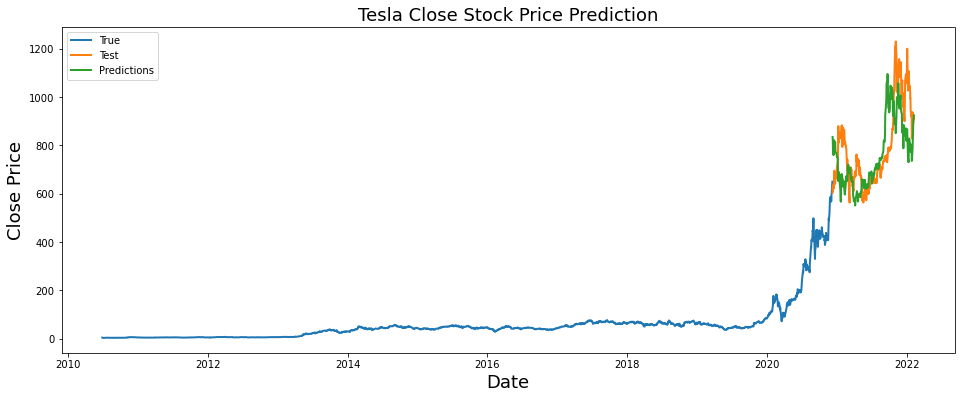

In [163]:
plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train_val['Close'], linewidth= 2)
plt.plot(test['Close'], linewidth= 2)
plt.plot(test["Predictions"], linewidth= 2)
plt.legend(['True', 'Test', 'Predictions'])
plt.ion()

# Result:

|Input            | MSE     |MAE    |MAPE   |
|-----------------|---------|-------|-------|
|Without Time2Vec |20005.07 |121.77 |14.13  |
| With TIme2Vec   |3662.66  |46.36  |5.30   |